In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import post_patch as pp #post patch script


sns.set_style('whitegrid') #Makes a white backround with gray horizontal gridmarks at y-values
sns.set_context('notebook')

In [2]:
def get_json_df():
    """To create json_df(dates:2017-10-02 to 2019-01-15).
    
    Arguements: None
    
    Returns: json_df
    """
        
    json_df = pd.read_csv('C:/users/ramr/documents/github/personal-projects/csv/json_metadata.csv')
    json_df = json_df[json_df['status'] == 'SUCCESS']
    
    json_df.dropna(subset = ['patch_container', 'cell_depth'], inplace = True)
    json_df = json_df[json_df['patch_container'].str.match('PA')]

    #Creates patch_duration column and outputs in minutes
    json_df['patch_duration'] = pd.to_datetime(json_df['extraction.timeRetractionEnd']) - pd.to_datetime(json_df['recording.timeWholeCellStart'])
    json_df['patch_duration'] = (json_df['patch_duration'].astype('timedelta64[s]'))/60

    json_df = pp.postpatch_reclass(json_df) #Makes post patch column with the script

    json_df = json_df[['date', 
                       'patch_container', 
                       'patch_duration',
                       'cell_depth',
                       'extraction.endPipetteR',
                       'post_patch']]
                       #'extraction.extractionNotes']]
    
    json_df['date'] = json_df['date'].str[:10] #Strip away the time
    json_df['date'] = pd.to_datetime(json_df['date']) #Converting to YYYY-MM-DD
    json_df.sort_values(by = ['date'], inplace = True) #Sorts date column
    return json_df

In [3]:
def get_shiny_df():
    """To create shiny_df with resolution index and cluster label by combining shiny_mouse and human csv.
    
    Arguements: None
    
    Returns: shiny_df
    """    
    
    shiny_human_df = pd.read_csv('C:/users/ramr/documents/github/personal-projects/csv/shiny_human.csv')
    shiny_mouse_df = pd.read_csv('C:/users/ramr/documents/github/personal-projects/csv/shiny_mouse.csv')
    frames = (shiny_human_df, shiny_mouse_df)
    shiny_df = pd.concat(frames)
    shiny_df = shiny_df.loc[:,['sample_id', 'res_index_label', 'cluster_label']]
    return shiny_df

In [4]:
def get_morph_df():
    """To create morph_df with 63x images information.
    
    Arguements: None
    
    Returns: morph_df
    """
    
    morph_df = pd.read_csv("C:/users/ramr/documents/github/personal-projects/csv/63x.csv")
    morph_df = morph_df.loc[:,['patched_cell_container', 
                               'ims63x_go_no_go', 
                               'ims63x_imaging_started', 
                               'image_series_63x_qc',
                               'link_ims_20x',
                               'link_ims_63x']]
    morph_df.sort_values(by = ['patched_cell_container'], inplace=True) #Sorts date column
    return morph_df

In [5]:
def merge_dfs(df1, df2, df3):
    merged_df = pd.merge(left = df1, 
                         right = df2, 
                         left_on = 'patch_container',
                         right_on = 'sample_id',
                         how = 'left')
    merged_df = pd.merge(left = merged_df, 
                         right = df3, 
                         left_on = 'patch_container',
                         right_on = 'patched_cell_container',
                         how = 'inner')
    
    merged_df.drop(['sample_id', 'patched_cell_container'], axis = 1, inplace = True)
    merged_df.dropna(subset=['res_index_label', 'ims63x_go_no_go'], inplace=True)
    return merged_df

In [6]:
def sort_df(df):
    """To sort dataframe to only show 2018 data.
    
    Arguements: 
        df: pandas dataframe
        
    Returns: df
    """
    
    df = df.set_index('date') #Set date column as index column 
    start_date = '2018-01-01'
    end_date = '2018-12-31'
    df = df[start_date:end_date] #Choosing start & end date
    df.sort_index(inplace=True)
    df.reset_index(inplace=True)
    return df

In [7]:
def piv_table(final_df):
    final_df1 = final_df.loc[:,['post_patch', 'ims63x_go_no_go', 'cell_depth']]
    final_df1 = final_df.groupby(['post_patch', 'ims63x_go_no_go']).count()
    final_df1 = final_df1.rename(columns = {'cell_depth' : ''})
    final_df1.reset_index(inplace = True)

    final_df1 = final_df1.pivot_table(values=[''], 
                                      index=['post_patch'], 
                                      columns = ['ims63x_go_no_go'], 
                                      aggfunc='sum')
    return final_df1

In [8]:
#Making global variables
json_df = get_json_df()
shiny_df = get_shiny_df()
morph_df = get_morph_df()
merged_df = merge_dfs(json_df, shiny_df, morph_df)
final_df = sort_df(merged_df) #final_all_df Dates: 2018-01-03 to 2018-11-20
final_df1 = piv_table(final_df)

C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2818: DtypeWarning: Columns (177) have mixed types. Specify dtype option on import or set low_memory=Fals

In [9]:
json_df.head()

date      patch_container  patch_duration  cell_depth  \
223 2017-10-02  PAS4_171002_451_A01       11.866667        47.4   
242 2017-10-03  PAS4_171003_451_A01       14.483333        36.6   
266 2017-10-03  PAS4_171003_452_A01       12.500000        36.3   
294 2017-10-04  PAS4_171004_452_A01        9.633333        39.1   
303 2017-10-04  PAS4_171004_453_A01       14.350000        36.0   

     extraction.endPipetteR     post_patch  
223                    10.2    No-low seal  
242                  2500.0  Nuc-high seal  
266                  1500.0  Nuc-high seal  
294                  3000.0  Nuc-high seal  
303                   250.0  Nuc-high seal

In [10]:
merged_df.head()

date      patch_container  patch_duration  cell_depth  \
0 2017-10-02  PAS4_171002_451_A01       11.866667        47.4   
1 2017-10-03  PAS4_171003_451_A01       14.483333        36.6   
2 2017-10-03  PAS4_171003_452_A01       12.500000        36.3   
3 2017-10-04  PAS4_171004_452_A01        9.633333        39.1   
4 2017-10-04  PAS4_171004_453_A01       14.350000        36.0   

   extraction.endPipetteR     post_patch  res_index_label     cluster_label  \
0                    10.2    No-low seal         0.434669               n59   
1                  2500.0  Nuc-high seal         0.548225               n60   
2                  1500.0  Nuc-high seal         1.000000        Pvalb Tpbg   
3                  3000.0  Nuc-high seal         1.000000         Sst Chodl   
4                   250.0  Nuc-high seal         1.000000  L4 IT VISp Rspo1   

  ims63x_go_no_go ims63x_imaging_started       image_series_63x_qc  \
0       63x no go                    NaN                       NaN   
1       63x no go                    NaN                       NaN   
2          63x go    63x imaging started           image_qc_passed   
3          63x go    63x imaging started  ready_for_dendrite_trace   
4          63x go    63x imaging started                  deferred   

                                        link_ims_20x  \
0  http://lims2/focal_plane_image_series?id=64349...   
1  http://lims2/focal_plane_image_series?id=64349...   
2  http://lims2/focal_plane_image_series?id=64349...   
3  http://lims2/focal_plane_image_series?id=64350...   
4  http://lims2/focal_plane_image_series?id=64350...   

                                        link_ims_63x  
0                                                NaN  
1                                                NaN  
2  http://lims2/focal_plane_image_series?id=64726...  
3  http://lims2/focal_plane_image_series?id=65053...  
4  http://lims2/focal_plane_image_series?id=66583...

In [11]:
final_df.head()

date      patch_container  patch_duration  cell_depth  \
0 2018-01-03  PAS4_180103_452_A01        9.083333        33.8   
1 2018-01-03  PAS4_180103_451_A01        9.800000        32.9   
2 2018-01-08  PAS4_180108_452_A01       10.850000        52.0   
3 2018-01-08  PAS4_180108_451_A01       11.166667        45.4   
4 2018-01-08  PAS4_180108_454_A01       10.433333        22.9   

   extraction.endPipetteR     post_patch  res_index_label    cluster_label  \
0                  1500.0  Nuc-high seal         1.000000  Sst Hpse Sema3c   
1                  1500.0  Nuc-high seal         0.868238             n107   
2                  2000.0  Nuc-high seal         1.000000       Pvalb Tpbg   
3                  1500.0  Nuc-high seal         0.467257              n88   
4                     5.9   Nuc-low seal         1.000000   Vip Ptprt Pkp2   

  ims63x_go_no_go ims63x_imaging_started       image_series_63x_qc  \
0          63x go    63x imaging started                  deferred   
1       63x no go                    NaN                       NaN   
2          63x go    63x imaging started  ready_for_dendrite_trace   
3          63x go    63x imaging started  ready_for_dendrite_trace   
4       63x no go                    NaN                       NaN   

                                        link_ims_20x  \
0  http://lims2/focal_plane_image_series?id=65748...   
1  http://lims2/focal_plane_image_series?id=65748...   
2  http://lims2/focal_plane_image_series?id=65795...   
3  http://lims2/focal_plane_image_series?id=65795...   
4  http://lims2/focal_plane_image_series?id=65795...   

                                        link_ims_63x  
0  http://lims2/focal_plane_image_series?id=66389...  
1                                                NaN  
2  http://lims2/focal_plane_image_series?id=66937...  
3  http://lims2/focal_plane_image_series?id=66940...  
4                                                NaN

In [12]:
final_df.tail()

date      patch_container  patch_duration  cell_depth  \
356 2018-11-15  PAS4_181115_451_A01       12.166667        56.8   
357 2018-11-15  PAS4_181115_455_A01       12.533333        69.7   
358 2018-11-16  PAS4_181116_452_A01        7.000000        65.7   
359 2018-11-16  PAS4_181116_451_A01       13.566667        61.5   
360 2018-11-20  PAS4_181120_451_A01       10.016667        68.5   

     extraction.endPipetteR     post_patch  res_index_label  \
356                  3500.0  Nuc-high seal         1.000000   
357                  2500.0  Nuc-high seal         1.000000   
358                  2000.0  Nuc-high seal         0.548225   
359                  2000.0  Nuc-high seal         0.813394   
360                    60.0  Nuc-high seal         1.000000   

            cluster_label ims63x_go_no_go ims63x_imaging_started  \
356      Sst Calb2 Pdlim5          63x go    63x imaging started   
357    Vip Crispld2 Kcne4       63x no go                    NaN   
358                   n60       63x no go                    NaN   
359                   n86       63x no go                    NaN   
360  Inh L2-4 PVALB WFDC2       63x no go                    NaN   

    image_series_63x_qc                                       link_ims_20x  \
356                 NaN  http://lims2/focal_plane_image_series?id=78999...   
357                 NaN  http://lims2/focal_plane_image_series?id=78999...   
358                 NaN  http://lims2/focal_plane_image_series?id=78999...   
359                 NaN  http://lims2/focal_plane_image_series?id=78999...   
360                 NaN  http://lims2/focal_plane_image_series?id=79000...   

    link_ims_63x  
356          NaN  
357          NaN  
358          NaN  
359          NaN  
360          NaN

In [13]:
final_df1

ims63x_go_no_go 63x go 63x no go
post_patch                      
Entire cell        NaN       3.0
No-high seal       NaN       5.0
No-low seal        NaN       9.0
Nuc-high seal    178.0     145.0
Nuc-low seal       4.0      17.0

In [14]:
#Rusty's Method figure it out later
post_patch_totals = list(final_df1.sum(1))
post_patch_totals = [int(x) for x in post_patch_totals]

In [15]:
final_df1 = final_df1.div(final_df1.sum(1), axis=0) * 100

In [16]:
final_df1

ims63x_go_no_go     63x go   63x no go
post_patch                            
Entire cell            NaN  100.000000
No-high seal           NaN  100.000000
No-low seal            NaN  100.000000
Nuc-high seal    55.108359   44.891641
Nuc-low seal     19.047619   80.952381

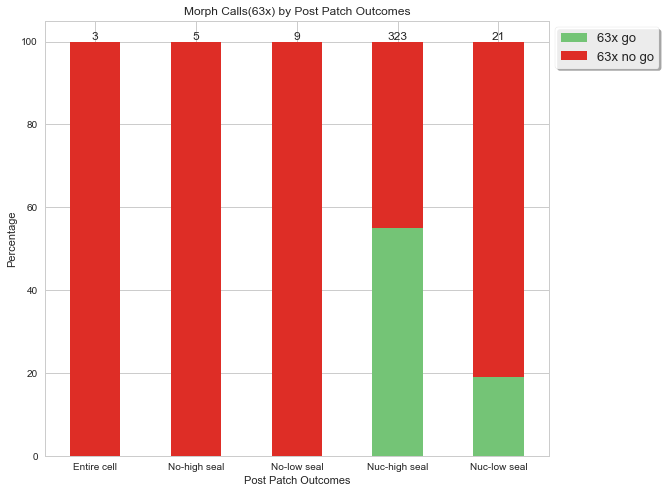

In [17]:
#order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal', 'Entire cell']
#.loc[order] lets you choose the order

def stacked_plot():
    my_colors = ['#74c476', '#de2d26']
    bp = final_df1.plot.bar(stacked = True, 
                            color = my_colors, 
                            figsize= (10,8),
                            rot = 0)

    bp.legend(['63x go', '63x no go'],
              loc = 0, 
              bbox_to_anchor = (1, 1), 
              frameon = True, 
              shadow = True,
              fontsize = 13)

    plt.subplots_adjust(left = 0.1, right = 0.8, bottom = None, top = None, wspace=None, hspace=None)
    #This helps if axis labels are getting cutoff when saving final image

    #Rusty's Method figure it out later
    rects = bp.patches
    labels = post_patch_totals

    #Rusty's Method figure it out later
    for rect, label in zip (rects, labels):
        height = 100
        x_value = rect.get_x() + rect.get_width() / 2
        bp.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', size = 12)

    bp.set_title('Morph Calls(63x) by Post Patch Outcomes')
    bp.set(xlabel = 'Post Patch Outcomes', ylabel = 'Percentage')

In [ ]:
stacked_plot()

### Dataframe Info

### Dataframe info

In [1]:
def df_info():
    """To view information about the multiple dataframes.
    
    Arguements: None
    
    Returns: None
    """
    print("merged_df")
    merged_df.info()
    print()
    print("final_df")
    final_df.info()